# Deep Learning Models

This strategy attempts to use deep learning to predict future stock prices.

## Initialization

In [54]:
# initialize the module and import all libraries
from init import *
import torch
import torch.nn as nn
import torch.optim as optim

## Config

### Data Range and Symbols

In [55]:
START_DATE = "2020-01-01"
END_DATE = "2023-01-01"
VAL_START_DATE = "2023-01-01"
VAL_END_DATE = "2024-01-01"
TEST_START_DATE = "2023-01-01"
TEST_END_DATE = "2024-01-01"
INTERVAL = "1d"
SYMBOL = "SPY"
INDICATOR_SYMBOLS = ["AAPL", "NVDA", "MSFT", "AMZN", "SBUX"]

### Indicator Config

In [56]:
EMA_RATIO_SPAN = 20

BBP_WINDOW_SIZE = 10
BBP_NUM_STDDEVS = 2

PPO_SHORT_SPAN = 5
PPO_LONG_SPAN = 30

MOMENTUM_LOOKBACK_1 = 1
MOMENTUM_LOOKBACK_2 = 5
MOMENTUM_LOOKBACK_3 = 20

### Prediction Config

In [57]:
LOOKAHEAD_RETURNS = 5

## Data Collection and Preparation

In [58]:
tickers = [SYMBOL] + INDICATOR_SYMBOLS

In [59]:
df = yf.download(tickers=tickers, start=START_DATE, end=END_DATE, interval=INTERVAL)["Adj Close"]
df.head()

[*********************100%%**********************]  6 of 6 completed


,AAPL,AMZN,MSFT,NVDA,SBUX,SPY
Date,,,,,,
2020-01-02,73.152641,94.900497,154.779510,59.744045,82.392883,305.058441
2020-01-03,72.441452,93.748497,152.852264,58.787777,81.913391,302.748474
2020-01-06,73.018692,95.143997,153.247330,59.034313,81.267868,303.903381
2020-01-07,72.675285,95.343002,151.850021,59.749023,81.018890,303.048950
2020-01-08,73.844337,94.598503,154.268784,59.861084,81.959480,304.664093


In [60]:
normalized_columns = [f"{ticker} Normalized" for ticker in tickers]


def add_normalized_columns(df: pd.DataFrame):
    for ticker, normalized_column in zip(tickers, normalized_columns):
        df[normalized_column] = df[ticker] / df[ticker].iloc[0]


add_normalized_columns(df=df)
df.head()

,AAPL,AMZN,MSFT,NVDA,SBUX,SPY,SPY Normalized,AAPL Normalized,NVDA Normalized,MSFT Normalized,AMZN Normalized,SBUX Normalized
Date,,,,,,,,,,,,
2020-01-02,73.152641,94.900497,154.779510,59.744045,82.392883,305.058441,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-03,72.441452,93.748497,152.852264,58.787777,81.913391,302.748474,0.992428,0.990278,0.983994,0.987548,0.987861,0.994180
2020-01-06,73.018692,95.143997,153.247330,59.034313,81.267868,303.903381,0.996214,0.998169,0.988120,0.990101,1.002566,0.986346
2020-01-07,72.675285,95.343002,151.850021,59.749023,81.018890,303.048950,0.993413,0.993475,1.000083,0.981073,1.004663,0.983324
2020-01-08,73.844337,94.598503,154.268784,59.861084,81.959480,304.664093,0.998707,1.009456,1.001959,0.996700,0.996818,0.994740


In [61]:
daily_returns_columns = [f"{ticker} Daily Returns" for ticker in tickers]


def add_returns_columns(df: pd.DataFrame):
    for ticker, daily_returns_column in zip(tickers, daily_returns_columns):

        df[daily_returns_column] = df[ticker] / df[ticker].shift(1) - 1


add_returns_columns(df=df)
df.head()

,AAPL,AMZN,MSFT,NVDA,SBUX,SPY,SPY Normalized,AAPL Normalized,NVDA Normalized,MSFT Normalized,AMZN Normalized,SBUX Normalized,SPY Daily Returns,AAPL Daily Returns,NVDA Daily Returns,MSFT Daily Returns,AMZN Daily Returns,SBUX Daily Returns
Date,,,,,,,,,,,,,,,,,,
2020-01-02,73.152641,94.900497,154.779510,59.744045,82.392883,305.058441,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,72.441452,93.748497,152.852264,58.787777,81.913391,302.748474,0.992428,0.990278,0.983994,0.987548,0.987861,0.994180,-0.007572,-0.009722,-0.016006,-0.012452,-0.012139,-0.005820
2020-01-06,73.018692,95.143997,153.247330,59.034313,81.267868,303.903381,0.996214,0.998169,0.988120,0.990101,1.002566,0.986346,0.003815,0.007968,0.004194,0.002585,0.014886,-0.007881
2020-01-07,72.675285,95.343002,151.850021,59.749023,81.018890,303.048950,0.993413,0.993475,1.000083,0.981073,1.004663,0.983324,-0.002812,-0.004703,0.012107,-0.009118,0.002092,-0.003064
2020-01-08,73.844337,94.598503,154.268784,59.861084,81.959480,304.664093,0.998707,1.009456,1.001959,0.996700,0.996818,0.994740,0.005330,0.016086,0.001876,0.015929,-0.007809,0.011610


## Data Visualization

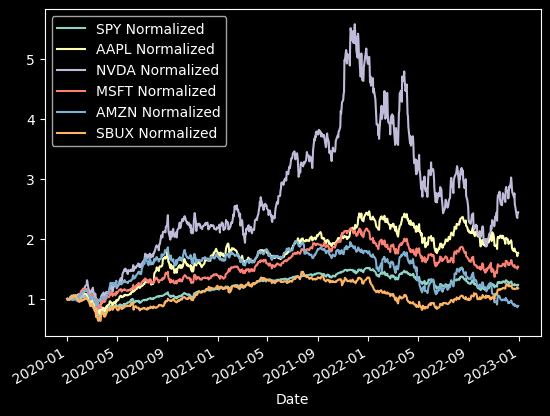

In [62]:
df[normalized_columns].plot()
plt.show()

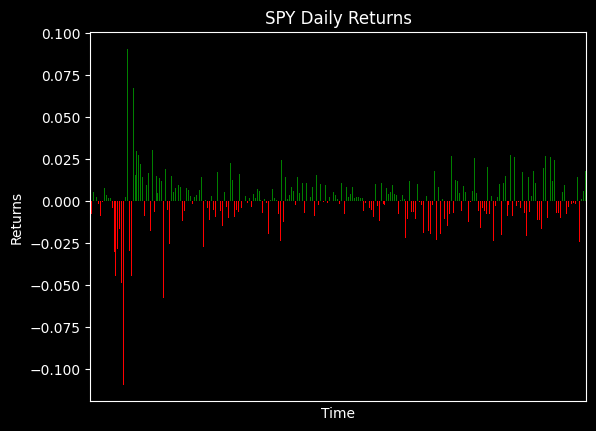

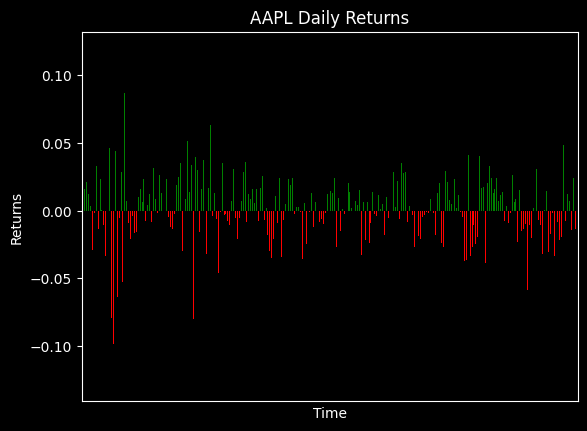

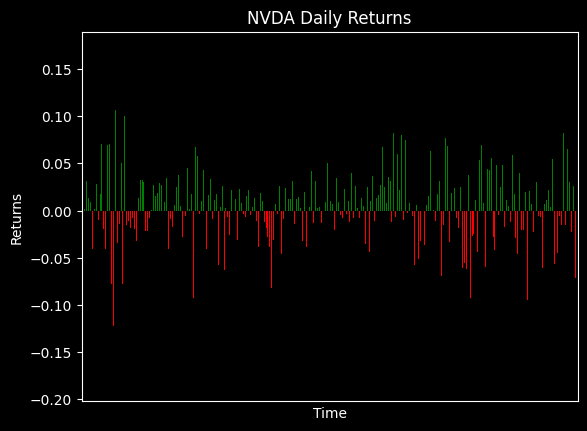

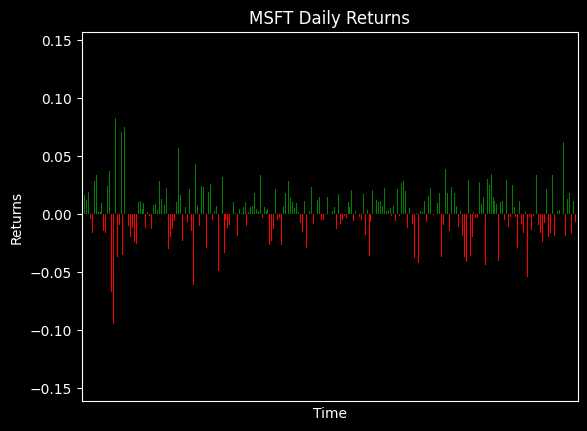

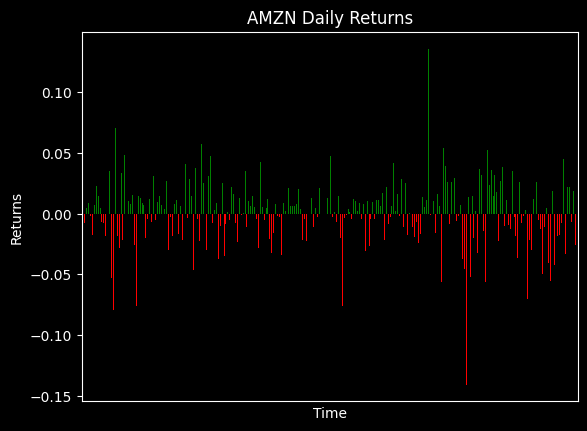

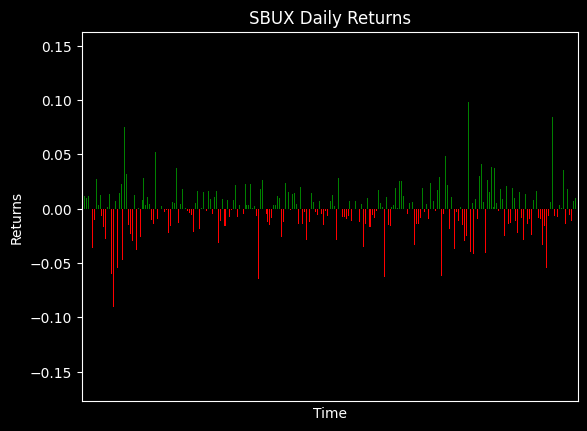

In [63]:
for daily_returns_column in daily_returns_columns:
    plot_returns(returns_df=df[daily_returns_column], title=daily_returns_column)
    plt.show()

## Indicator Calculations

In [64]:
indicator_columns = sum(
    [
        [
            f"{symbol}_ema_ratio",
            f"{symbol}_bbp",
            f"{symbol}_ppo",
            f"{symbol}_momentum_1",
            f"{symbol}_momentum_2",
            f"{symbol}_momentum_3",
        ]
        for symbol in tickers
    ],
    [],
)


def add_indicator_columns(df: pd.DataFrame):
    for symbol, normalized_column in zip(tickers, normalized_columns):
        normalized_prices: pd.Series = df[normalized_column]


        # compute ema ratio
        ema = normalized_prices.ewm(span=10).mean()
        df[f"{symbol}_ema_ratio"] = normalized_prices / ema - 1


        # compute bbp
        rolling_prices = normalized_prices.rolling(window=BBP_WINDOW_SIZE)
        sma = rolling_prices.mean()
        sm_std = rolling_prices.std()

        lower_band = sma - sm_std * BBP_NUM_STDDEVS
        upper_band = sma + sm_std * BBP_NUM_STDDEVS

        df[f"{symbol}_bbp"] = (normalized_prices - lower_band) / (
            upper_band - lower_band
        ) - 0.5


        # compute ppo


        short_ema = normalized_prices.ewm(span=PPO_SHORT_SPAN, adjust=False).mean()
        long_ema = normalized_prices.ewm(span=PPO_LONG_SPAN, adjust=False).mean()

        df[f"{symbol}_ppo"] = short_ema / long_ema - 1


        # compute momentum 1
        df[f"{symbol}_momentum_1"] = (
            normalized_prices / normalized_prices.shift(MOMENTUM_LOOKBACK_1) - 1
        )

        # compute momentum 2
        df[f"{symbol}_momentum_2"] = (
            normalized_prices.shift(MOMENTUM_LOOKBACK_1)
            / normalized_prices.shift(MOMENTUM_LOOKBACK_2)
            - 1
        )

        # compute momentum 2
        df[f"{symbol}_momentum_3"] = (
            normalized_prices.shift(MOMENTUM_LOOKBACK_2)
            / normalized_prices.shift(MOMENTUM_LOOKBACK_2)
            - 1
        )


add_indicator_columns(df=df)
df.head()

,AAPL,AMZN,MSFT,NVDA,SBUX,SPY,SPY Normalized,AAPL Normalized,NVDA Normalized,MSFT Normalized,...,AMZN_ppo,AMZN_momentum_1,AMZN_momentum_2,AMZN_momentum_3,SBUX_ema_ratio,SBUX_bbp,SBUX_ppo,SBUX_momentum_1,SBUX_momentum_2,SBUX_momentum_3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,73.152641,94.900497,154.779510,59.744045,82.392883,305.058441,1.000000,1.000000,1.000000,1.000000,...,0.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
2020-01-03,72.441452,93.748497,152.852264,58.787777,81.913391,302.748474,0.992428,0.990278,0.983994,0.987548,...,-0.003266,-0.012139,NaN,NaN,-0.002627,NaN,-0.001565,-0.005820,NaN,NaN
2020-01-06,73.018692,95.143997,153.247330,59.034313,81.267868,303.903381,0.996214,0.998169,0.988120,0.990101,...,-0.001276,0.014886,NaN,NaN,-0.006298,NaN,-0.004618,-0.007881,NaN,NaN
2020-01-07,72.675285,95.343002,151.850021,59.749023,81.018890,303.048950,0.993413,0.993475,1.000083,0.981073,...,0.000556,0.002092,NaN,NaN,-0.006284,NaN,-0.007243,-0.003064,NaN,NaN
2020-01-08,73.844337,94.598503,154.268784,59.861084,81.959480,304.664093,0.998707,1.009456,1.001959,0.996700,...,-0.000423,-0.007809,NaN,NaN,0.003739,NaN,-0.005646,0.011610,NaN,NaN


In [65]:
lookahead_returns_column = f"{SYMBOL}_lookahead_returns"


def add_lookahead_returns_column(df: pd.DataFrame):
    df[lookahead_returns_column] = df[SYMBOL].shift(-LOOKAHEAD_RETURNS) / df[SYMBOL] - 1


add_lookahead_returns_column(df=df)
df[lookahead_returns_column].head()

Date
2020-01-02    0.005479
2020-01-03    0.010236
2020-01-06    0.013318
2020-01-07    0.014625
2020-01-08    0.011527
Name: SPY_lookahead_returns, dtype: float64

In [66]:
cleaned_df = df.dropna()
print(len(cleaned_df))
cleaned_df.head()

742


,AAPL,AMZN,MSFT,NVDA,SBUX,SPY,SPY Normalized,AAPL Normalized,NVDA Normalized,MSFT Normalized,...,AMZN_momentum_1,AMZN_momentum_2,AMZN_momentum_3,SBUX_ema_ratio,SBUX_bbp,SBUX_ppo,SBUX_momentum_1,SBUX_momentum_2,SBUX_momentum_3,SPY_lookahead_returns
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-15,75.829353,93.100998,157.246414,61.153542,84.412361,308.175903,1.010219,1.036591,1.023592,1.015938,...,-0.003969,-0.011908,0.0,0.013457,0.346720,0.012604,0.006045,0.023740,0.0,0.010756
2020-01-16,76.779221,93.897003,160.127747,61.990265,85.371391,310.739502,1.018623,1.049576,1.037597,1.034554,...,0.008550,-0.020531,0.0,0.019769,0.401928,0.017202,0.011361,0.011157,0.0,-0.006497
2020-01-17,77.629250,93.236000,161.023941,62.077423,86.330406,311.706696,1.021793,1.061195,1.039056,1.040344,...,-0.007040,-0.002772,0.0,0.024831,0.415074,0.022767,0.011233,0.026841,0.0,-0.025456
2020-01-21,77.103157,94.599998,160.445709,61.743729,85.325264,311.096252,1.019792,1.054004,1.033471,1.036608,...,0.014630,-0.014054,0.0,0.010341,0.223021,0.022484,-0.011643,0.027888,0.0,-0.013311
2020-01-22,77.378387,94.373001,159.674835,62.284115,85.325264,311.133850,1.019916,1.057766,1.042516,1.031628,...,-0.002400,0.012068,0.0,0.008324,0.193106,0.021813,0.000000,0.016925,0.0,-0.014245


In [67]:
X_tensor = torch.from_numpy(cleaned_df[indicator_columns].values)
Y_tensor = torch.from_numpy(cleaned_df[[lookahead_returns_column]].values)
X_tensor.shape, Y_tensor.shape

(torch.Size([742, 36]), torch.Size([742, 1]))

## Research

### Basic Neural Network Model

In [68]:
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(len(indicator_columns), 20),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.25),
            nn.Linear(20, 10),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.25),
            nn.Linear(10, 1),
        ])

    def forward(self, x):
        z = x
        for layer in self.layers:
            z = layer(z)
        return z

In [69]:
basic_model = BasicModel().double()
loss_criterion = nn.MSELoss()
optimizer = optim.Adam(params=basic_model.parameters(), lr=1e-3)

NUM_EPOCHS = 500
losses = []

print(basic_model)
print(loss_criterion)
print(optimizer)

BasicModel(
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [70]:
basic_model.train(True)

for epoch in range(NUM_EPOCHS):
    perm = torch.randperm(X_tensor.shape[0])
    X_tensor_shuffled = X_tensor[perm]
    Y_tensor_shuffled = Y_tensor[perm]

    optimizer.zero_grad()

    Y_hat_tensor_shuffled = basic_model(X_tensor_shuffled)
    loss = loss_criterion(Y_hat_tensor_shuffled, Y_tensor_shuffled)
    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch}: loss={losses[-1]}")

_ = basic_model.train(False)


Epoch 0: loss=0.019841506023606025
Epoch 1: loss=0.019111611688312848
Epoch 2: loss=0.01819948070000306
Epoch 3: loss=0.01744480649283056
Epoch 4: loss=0.016288787259772848
Epoch 5: loss=0.015656354826228517
Epoch 6: loss=0.014757830002936281
Epoch 7: loss=0.013696572305749772
Epoch 8: loss=0.013316548170584086
Epoch 9: loss=0.012634422684078626
Epoch 10: loss=0.011890318131859897
Epoch 11: loss=0.011708082919429126
Epoch 12: loss=0.010772574246117873
Epoch 13: loss=0.010377654682303871
Epoch 14: loss=0.00981565442940273
Epoch 15: loss=0.009336578217561266
Epoch 16: loss=0.008830205894310739
Epoch 17: loss=0.008357344489841666
Epoch 18: loss=0.007988415451600837
Epoch 19: loss=0.007638125252125695
Epoch 20: loss=0.007290629799054448
Epoch 21: loss=0.006623170879278532
Epoch 22: loss=0.006567559692087925
Epoch 23: loss=0.006257306458358992
Epoch 24: loss=0.0058109652361668755
Epoch 25: loss=0.005706691183581344
Epoch 26: loss=0.005270731717173875
Epoch 27: loss=0.005017001867278755
Epoc

Epoch 274: loss=0.001265306357328704
Epoch 275: loss=0.001371293283750537
Epoch 276: loss=0.0013334021220069308
Epoch 277: loss=0.001296645370459059
Epoch 278: loss=0.0013157295829002746
Epoch 279: loss=0.0013588229548167872
Epoch 280: loss=0.0013577411124649171
Epoch 281: loss=0.0013160093434820019
Epoch 282: loss=0.001317149156741918
Epoch 283: loss=0.001297586485487447
Epoch 284: loss=0.001339643057407171
Epoch 285: loss=0.0012494819244203647
Epoch 286: loss=0.001381256323595745
Epoch 287: loss=0.0012736219475763064
Epoch 288: loss=0.0013520940047690325
Epoch 289: loss=0.0012702045380443084
Epoch 290: loss=0.0012000727442776939
Epoch 291: loss=0.0013085822351453114
Epoch 292: loss=0.0013219349591983346
Epoch 293: loss=0.0012856623069746021
Epoch 294: loss=0.0012702294679292445
Epoch 295: loss=0.0012383280317292945
Epoch 296: loss=0.0013432458339190437
Epoch 297: loss=0.0012747550919055852
Epoch 298: loss=0.0012789421665442581
Epoch 299: loss=0.0012430887050582863
Epoch 300: loss=0.0

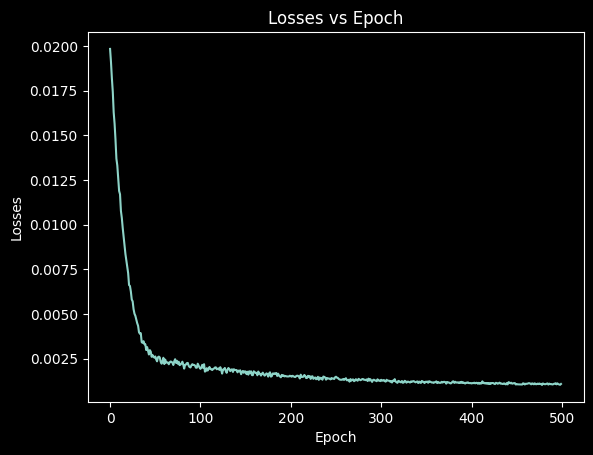

In [71]:
plt.plot(losses)
plt.title("Losses vs Epoch")
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.show()

In [72]:
predicted_lookahead_returns_column = f"{SYMBOL}_predicted_lookahead_returns"


def add_predicted_lookahead_returns_column(df: pd.DataFrame, model: nn.Module):
    with torch.no_grad():
        X_tensor = torch.from_numpy(df[indicator_columns].values)
        Y_hat_tensor = model(X_tensor)
    df[predicted_lookahead_returns_column] = Y_hat_tensor.numpy()


add_predicted_lookahead_returns_column(df=cleaned_df, model=basic_model)

In [73]:
predicted_lookahead_returns_uncertainty = (
    f"{SYMBOL}_predicted_lookahead_returns_uncertainty"
)
NUM_TRIALS = 32


def add_predicted_lookahead_returns_uncertainty_column(
    df: pd.DataFrame, model: nn.Module
):
    y_hats = []
    model.train(True)
    for _ in range(NUM_TRIALS):
        with torch.no_grad():
            X_tensor = torch.from_numpy(df[indicator_columns].values)
            Y_hat_tensor = model(X_tensor)
            y_hats.append(Y_hat_tensor.numpy())
    model.train(False)
    df[predicted_lookahead_returns_uncertainty] = np.std(y_hats, axis=0)


add_predicted_lookahead_returns_uncertainty_column(df=cleaned_df, model=basic_model)

In [74]:
lookahead_price_column = f"{SYMBOL}_lookahead_price"
predicted_lookahead_price_column = f"{SYMBOL}_predicted_lookahead_price"
predicted_lookahead_price_low_column = f"{SYMBOL}_predicted_lookahead_price_low"
predicted_lookahead_price_high_column = f"{SYMBOL}_predicted_lookahead_price_high"

NUM_STDDEVS = 2


def add_future_price_columns(df: pd.DataFrame):
    df[lookahead_price_column] = df[SYMBOL] * (df[lookahead_returns_column] + 1)
    df[predicted_lookahead_price_column] = df[SYMBOL] * (
        df[predicted_lookahead_returns_column] + 1
    )
    df[predicted_lookahead_price_low_column] = df[SYMBOL] * (
        df[predicted_lookahead_returns_column]
        + 1
        - NUM_STDDEVS * df[predicted_lookahead_returns_uncertainty]
    )
    df[predicted_lookahead_price_high_column] = df[SYMBOL] * (
        df[predicted_lookahead_returns_column]
        + 1
        + NUM_STDDEVS * df[predicted_lookahead_returns_uncertainty]
    )


add_future_price_columns(df=cleaned_df)
cleaned_df[
    [
        SYMBOL,
        lookahead_price_column,
        predicted_lookahead_price_column,
        predicted_lookahead_price_low_column,
        predicted_lookahead_price_high_column,
    ]
]

,SPY,SPY_lookahead_price,SPY_predicted_lookahead_price,SPY_predicted_lookahead_price_low,SPY_predicted_lookahead_price_high
Date,,,,,
2020-01-15,308.175903,311.490662,307.063292,302.470013,311.656571
2020-01-16,310.739502,308.720520,309.595984,304.275135,314.916833
2020-01-17,311.706696,303.771912,310.435030,305.508620,315.361439
2020-01-21,311.096252,306.955231,311.190556,305.133494,317.247617
2020-01-22,311.133850,306.701721,311.225263,304.886300,317.564225
...,...,...,...,...,...
2022-12-16,377.532013,377.177399,378.426818,370.356284,386.497353
2022-12-19,374.330658,375.690033,373.572419,365.451152,381.693686
2022-12-20,374.842896,371.020966,374.474139,367.565351,381.382928


In [75]:
direction_accuracy = (
    (cleaned_df[lookahead_returns_column] > 0)
    == (cleaned_df[predicted_lookahead_returns_column] > 0)
).sum() / cleaned_df.shape[0]
direction_accuracy

0.5566037735849056

<Axes: xlabel='Date'>

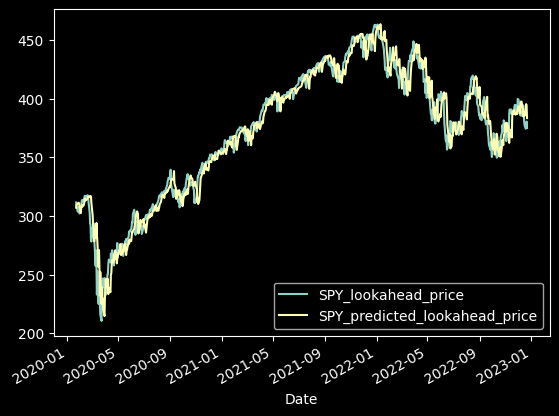

In [76]:
cleaned_df[
    [
        lookahead_price_column,
        predicted_lookahead_price_column,
    ]
].shift(LOOKAHEAD_RETURNS).plot()

In [77]:
val_df = yf.download(
    tickers=tickers, start=VAL_START_DATE, end=VAL_END_DATE, interval=INTERVAL
)["Adj Close"]
add_normalized_columns(df=val_df)
add_returns_columns(df=val_df)
add_indicator_columns(df=val_df)
add_lookahead_returns_column(df=val_df)
val_df = val_df.dropna()
add_predicted_lookahead_returns_column(df=val_df, model=basic_model)
add_predicted_lookahead_returns_uncertainty_column(df=val_df, model=basic_model)
add_future_price_columns(df=val_df)

[                       0%%                      ]

[*********************100%%**********************]  6 of 6 completed


In [78]:
val_df[
    [
        SYMBOL,
        lookahead_price_column,
        predicted_lookahead_price_column,
        predicted_lookahead_price_low_column,
        predicted_lookahead_price_high_column,
    ]
]

,SPY,SPY_lookahead_price,SPY_predicted_lookahead_price,SPY_predicted_lookahead_price_low,SPY_predicted_lookahead_price_high
Date,,,,,
2023-01-17,391.814911,394.208588,391.856289,384.361408,399.351170
2023-01-18,385.628937,394.356323,387.089222,378.038269,396.140176
2023-01-19,382.821655,398.690430,384.077684,377.052246,391.103122
2023-01-20,389.953278,399.606506,390.787070,383.673686,397.900454
2023-01-23,394.632111,394.592712,394.023838,386.913205,401.134471
...,...,...,...,...,...
2023-12-15,469.329987,473.649994,471.527845,460.954595,482.101095
2023-12-18,471.970001,475.649994,474.764455,464.607410,484.921500
2023-12-19,474.839996,476.510010,476.101647,464.773872,487.429422


In [79]:
val_direction_accuracy = (
    (val_df[lookahead_returns_column] > 0)
    == (val_df[predicted_lookahead_returns_column] > 0)
).sum() / val_df.shape[0]
val_direction_accuracy

0.5720338983050848

<Axes: xlabel='Date'>

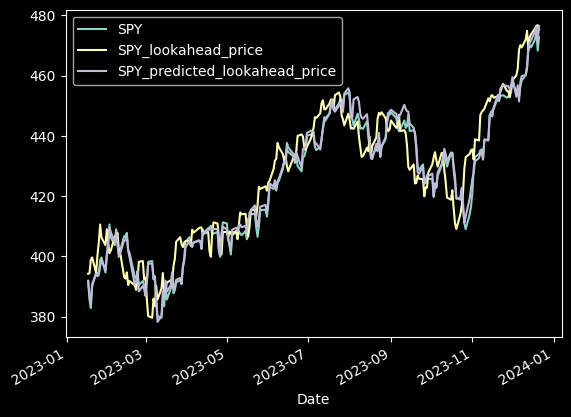

In [80]:
val_df[[SYMBOL, lookahead_price_column, predicted_lookahead_price_column]].plot()

<Axes: xlabel='Date'>

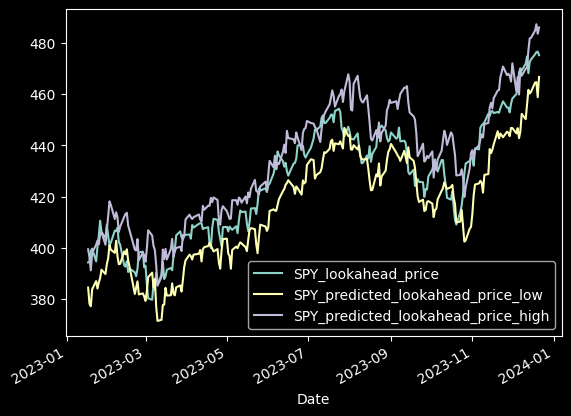

In [81]:
val_df[[lookahead_price_column, predicted_lookahead_price_low_column, predicted_lookahead_price_high_column]].plot()

<Axes: xlabel='Date'>

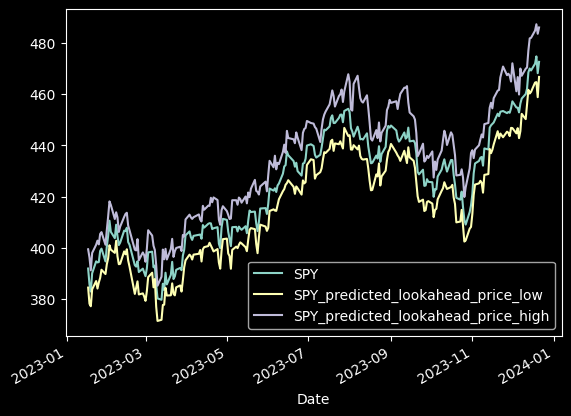

In [129]:
val_df[
    [
        SYMBOL,
        predicted_lookahead_price_low_column,
        predicted_lookahead_price_high_column,
    ]
].plot()

In [82]:
with torch.no_grad():
    X_val_tensor = torch.from_numpy(val_df[indicator_columns].values)
    Y_val_tensor = torch.from_numpy(val_df[[lookahead_returns_column]].values)
    Y_hat_val_tensor = basic_model(X_val_tensor)
    val_loss = loss_criterion(Y_hat_val_tensor, Y_val_tensor)
    print(val_loss.item())

0.00034022063734168596


## Strategy

In [124]:
holdings_column = f"{SYMBOL} Holdings"
trades_column = f"{SYMBOL} Trades"
cash_column = "CASH"
portfolio_value_column = "Portfolio Value"

STARTING_VALUE = 10000

TRADE_SIZE = 100

NUM_STDDEVS_TO_TRADE = 0.55


def add_trades_column(df: pd.DataFrame):
    df[cash_column] = 0.0
    df[holdings_column] = 0.0

    df[cash_column].iloc[0] = STARTING_VALUE

    for i in range(1, df.shape[0]):
        lookahead_return_uncertainty = df[predicted_lookahead_returns_uncertainty].iloc[
            i
        ]
        lookahead_return_prediction = df[predicted_lookahead_returns_column].iloc[i]
        if (
            lookahead_return_prediction
            - NUM_STDDEVS_TO_TRADE * lookahead_return_uncertainty
            > 0
        ):
            df[holdings_column].iloc[i] = TRADE_SIZE
        elif (
            lookahead_return_prediction
            + NUM_STDDEVS_TO_TRADE * lookahead_return_uncertainty
            < 0
        ):
            df[holdings_column].iloc[i] = -TRADE_SIZE
        else:
            df[holdings_column].iloc[i] = 0

        df[cash_column].iloc[i] = (
            -(df[holdings_column].iloc[i] - df[holdings_column].iloc[i - 1])
            * df[SYMBOL].iloc[i]
            + df[cash_column].iloc[i - 1]
        )

    df[trades_column] = df[holdings_column].diff()
    df[trades_column].iloc[0] = df[holdings_column].iloc[0]

    df[portfolio_value_column] = df[holdings_column] * df[SYMBOL] + df[cash_column]


add_trades_column(df=val_df)

In [125]:
profit = (
    val_df[portfolio_value_column].iloc[-1] - val_df[portfolio_value_column].iloc[0]
)
print(f"Start Value: {STARTING_VALUE}")
print(f"Profit: {profit}")
print(f"Returns: {np.round(100 * profit / STARTING_VALUE, 2)}%")

Start Value: 10000
Profit: 4833.75244140625
Returns: 48.34%


<Axes: xlabel='Date'>

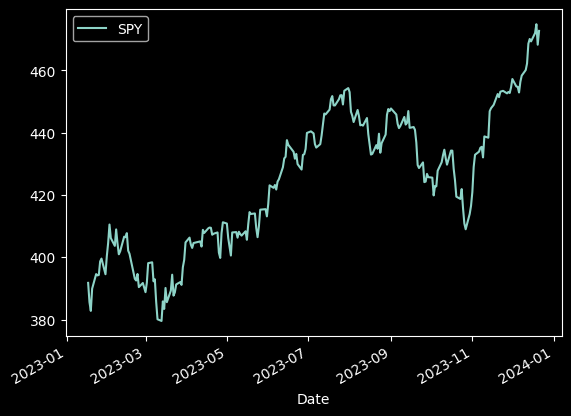

In [126]:
val_df[[SYMBOL]].plot()

<Axes: xlabel='Date'>

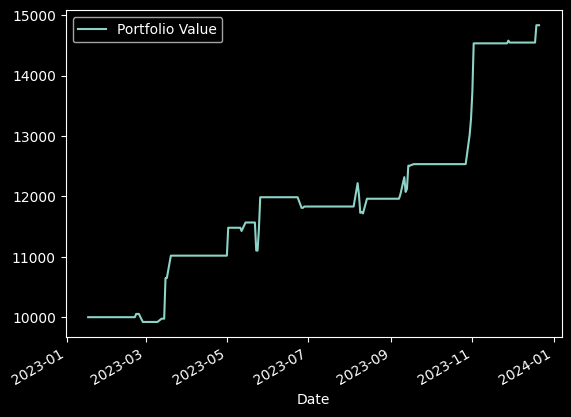

In [127]:
val_df[[portfolio_value_column]].plot()

<Axes: xlabel='Date'>

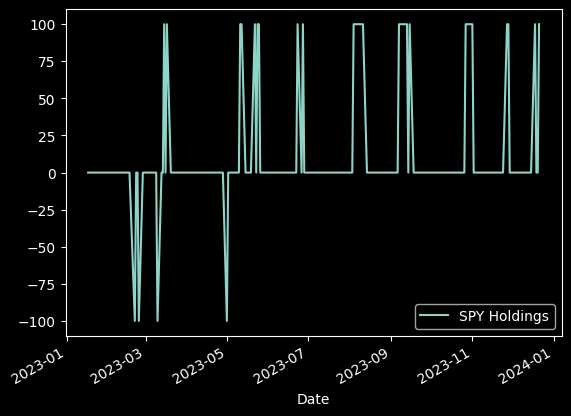

In [128]:
val_df[[holdings_column]].plot()

## Performance

## Testing